<a href="https://colab.research.google.com/github/mlkyufy/deep_learning_lstm_fall_detection/blob/main/Deep_learning_based_Fall_Detection_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro
 
For fall detection by smartphone, acceleration & gyroscobe sensors will be used to get various information such as different types of falls pattern as well as normal daily activties. will use data collected by a smartphone and then train an LSTM Neural Network. The trained model will be exported and saved and added to an Android app.

In [ ]:
!pip install tensorflow==1.13.1
!pip install keras==2.3.0

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

# Dataset
 
We will use data provided by the [MobiFall_Dataset_v2.0.rar](https://bmi.hmu.gr/the-mobifall-and-mobiact-datasets-2/) 
However, after it have been resampled to 50Hz to achaive better reading into LSTM
the data set contains 8 activities of normal daily life (walking ,jogging,standing , sitting , On chair, sit to stand ,stand to sit, laying) and  four type of falls (forward,on knee,, back chair, side fall). The meantioned activities and the falls have been categorised into two { Not_fall , Fall } to increase the classification accuracy to predict the falls
 
Let's have a closer look at the data: [ https://drive.google.com/file/d/1GXdYtD1gQHZQ9La3vvCYMV8Rkl0zLe8t/view?usp=sharing ]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
columns = ['activity','timestamp','realtime', 'x-acc', 'y-acc', 'z-acc', 'x-gyro', 'y-gyro', 'z-gyro']
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FYP/ALL(Fall-Not_Fall) - Copy.csv', header = None, names = columns)
df = df.dropna()

In [ ]:
df.head()

,activity,timestamp,realtime,x-acc,y-acc,z-acc,x-gyro,y-gyro,z-gyro
0,Not_Fall,2.140000e+12,0.000000,1.068618,9.995623,1.288512,7.861530,5.012455,1.132239
1,Not_Fall,2.140000e+12,0.019948,1.077557,10.064982,1.157302,-1.200358,0.762358,0.045511
2,Not_Fall,2.140000e+12,0.039929,1.244444,9.911720,1.904271,-1.192086,0.790736,0.034820
3,Not_Fall,2.140000e+12,0.059987,2.769314,10.050282,2.667405,-1.255935,0.770626,0.092540
4,Not_Fall,2.140000e+12,0.080188,1.925396,9.931339,1.776644,-1.243065,0.547792,0.182565


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209495 entries, 0 to 209494
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   activity   209495 non-null  object 
 1   timestamp  209495 non-null  float64
 2   realtime   209495 non-null  float64
 3   x-acc      209495 non-null  float64
 4   y-acc      209495 non-null  float64
 5   z-acc      209495 non-null  float64
 6   x-gyro     209495 non-null  float64
 7   y-gyro     209495 non-null  float64
 8   z-gyro     209495 non-null  float64
dtypes: float64(8), object(1)
memory usage: 16.0+ MB


# Exploration

The columns we will be most interested in is 'Fall'

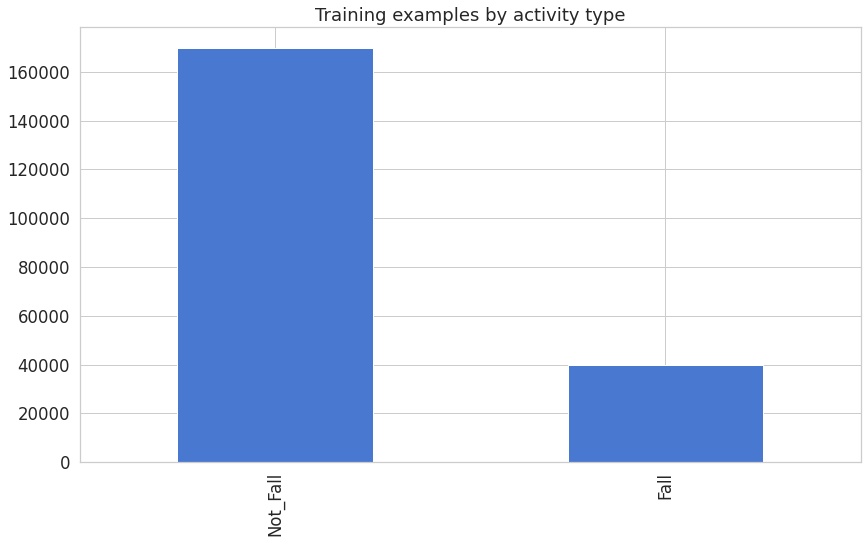

In [ ]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [ ]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-acc', 'y-acc', 'z-acc', 'x-gyro', 'y-gyro', 'z-gyro']][:200]
    axis = data.plot(subplots= False, figsize=(16, 12), 
                     title=activity)

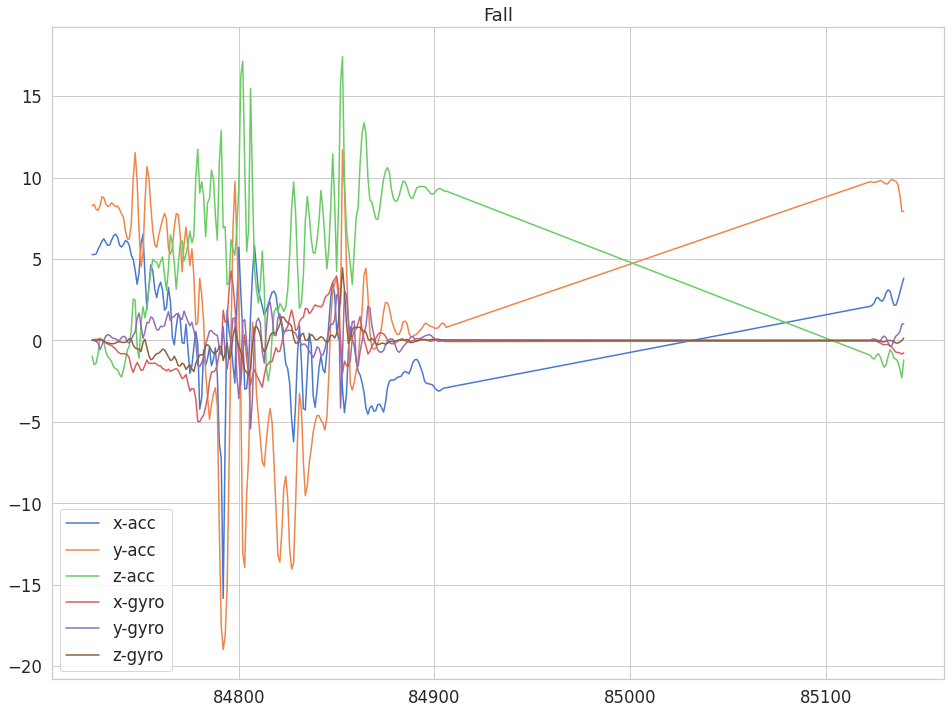

In [ ]:
plot_activity("Fall", df)

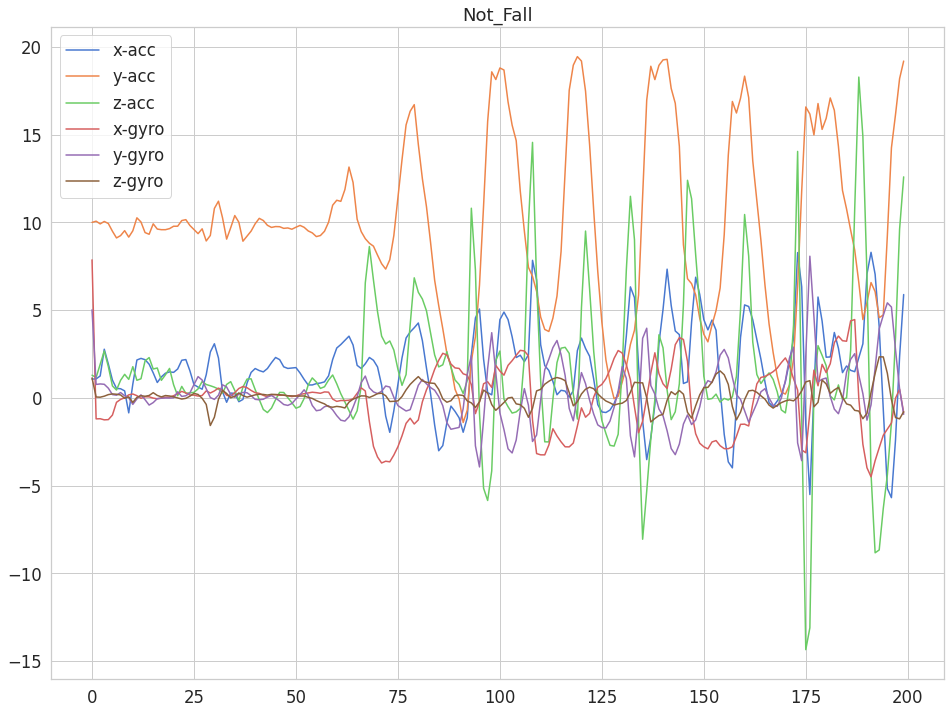

In [ ]:
plot_activity("Not_Fall", df)

It seems reasonable to assume that this data might be used to train a model that can distinguish between two different kinds of patterns.

# Data preprocessing

the LSTM model expects fixed-length sequences as training data. We'll use a familiar method for generating these. Each generated sequence contains 200 training examples:

In [ ]:
N_TIME_STEPS = 200
N_FEATURES = 6
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xc = df['x-acc'].values[i: i + N_TIME_STEPS]
    yc = df['y-acc'].values[i: i + N_TIME_STEPS]
    zc = df['z-acc'].values[i: i + N_TIME_STEPS]
    xg = df['x-gyro'].values[i: i + N_TIME_STEPS]
    yg = df['y-gyro'].values[i: i + N_TIME_STEPS]
    zg = df['z-gyro'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xc, yc, zc,xg,yg,zg])
    labels.append(label)

In [ ]:
np.array(segments).shape

(10465, 6, 200)

In [ ]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [ ]:
reshaped_segments.shape

(10465, 200, 6)

In [ ]:
labels[0]

array([0., 1.], dtype=float32)

to Split the data into training (80%) and test (20%) 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
len(X_train)


8372

In [ ]:
len(X_test)


2093

# Create the model
the model contains 2 fully-connected and 2 LSTM layers (stacked on each other) with 64 units each:

In [ ]:
N_CLASSES = 2
N_HIDDEN_UNITS = 64

In [ ]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [ ]:

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

Note that input tensor named as 'input' and output as 'y_' that will be useful when using the model in Android app.

In [ ]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


A regularizer that applies a regularization penalty and that must be noted in our loss. Regularizers allow you to apply penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes.

In [ ]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Finally, define optimizer and accuracy ops. 

Adam is an optimization algorithm that can be used  to update network weights iterative based in training data. Thus, learning rate that improves performance on problems with sparse gradients

In [ ]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# Training

The training part contains a lot of TensorFlow boilerplate. We will train the model for 50 epochs and keep track of accuracy and error:

In [ ]:
N_EPOCHS = 50
BATCH_SIZE = 1024

In [ ]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.833731472492218 loss: 1.3040719032287598
epoch: 10 test accuracy: 0.909699022769928 loss: 0.7819030284881592
epoch: 20 test accuracy: 0.9407548904418945 loss: 0.6034905910491943
epoch: 30 test accuracy: 0.9268991947174072 loss: 0.5473732352256775
epoch: 40 test accuracy: 0.9426660537719727 loss: 0.4614408016204834
epoch: 50 test accuracy: 0.944577157497406 loss: 0.4424707889556885

final results: accuracy: 0.944577157497406 loss: 0.4424707889556885


To store the model to the disk:

In [ ]:

pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', 'sfd.pbtxt')
saver.save(sess, save_path= "./checkpoint/sfd.ckpt")
sess.close()


And loading it back:

In [ ]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

# Evaluation

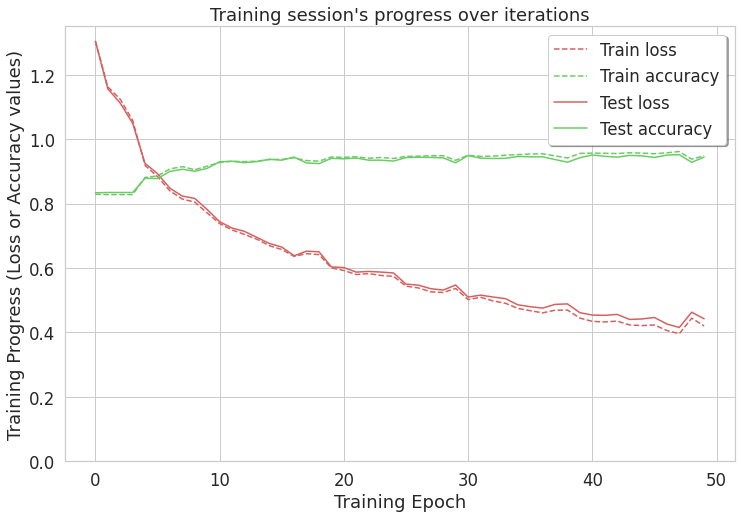

In [ ]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

The model seems to learn well 

TO have a look at the confusion matrix for the model's predictions:

In [ ]:
LABELS = ['Fall', 'Not_Fall']

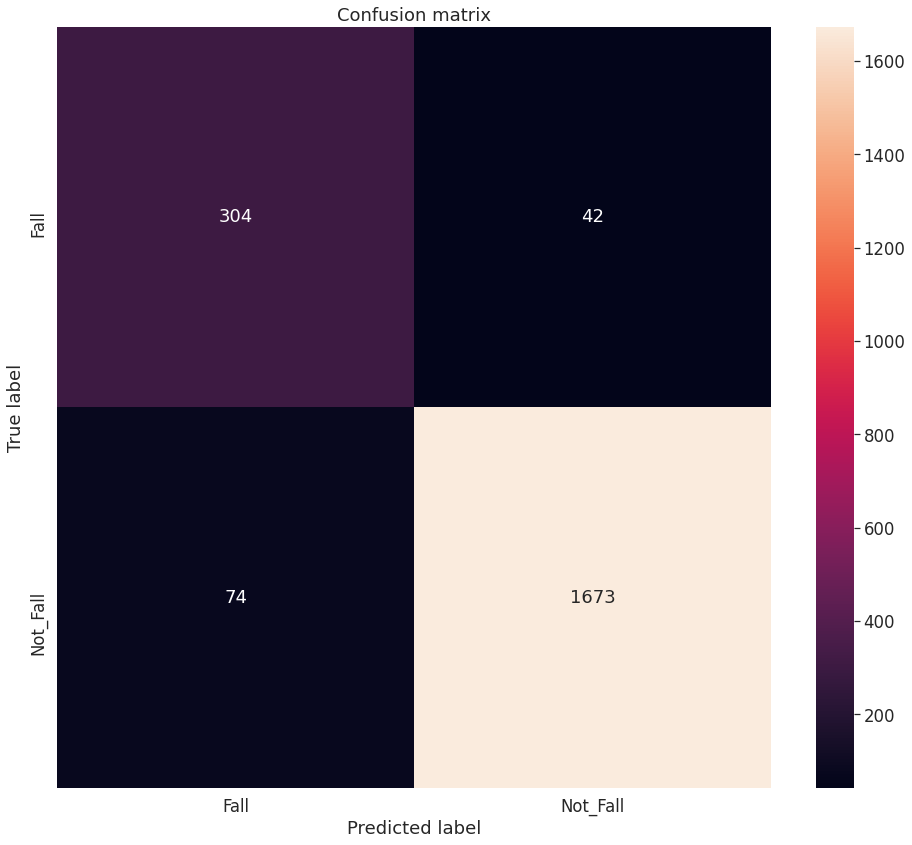

In [ ]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

Again, it looks like our model performs real good. Some notable exceptions include the misclassification  


# Testing

In [ ]:
#This is to test, if some other data is classified
testFile = '/content/drive/MyDrive/Colab Notebooks/0-FYP/ALL(Fall-Not_Fall) - Copy.csv'


testColumns =['activity','timestamp','realtime', 'x-acc', 'y-acc', 'z-acc', 'x-gyro', 'y-gyro', 'z-gyro']

df_test = pd.read_csv(testFile, header = None, names = testColumns)
df_test = df_test.dropna()

xcList = list(df_test['x-acc'])
ycList = list(df_test['y-acc'])
zcList = list(df_test['z-acc'])
xgList = list(df_test['x-gyro'])
ygList = list(df_test['y-gyro'])
zgList = list(df_test['z-gyro'])

counter = 1
correctCounter = 0;
for counter in range (1, 1000,1):
    xcSublist = []
    ycSublist = []
    zcSublist = []
    xgSublist = []
    ygSublist = []
    zgSublist = []
    segments_test = []

    for i in range(200*(counter-1),200*counter,1):
        xcSublist.append(xcList[i])
        ycSublist.append(ycList[i])
        zcSublist.append(zcList[i])
        xgSublist.append(xgList[i])
        ygSublist.append(ygList[i])
        zgSublist.append(zgList[i])

    segments_test.append([xcSublist, ycSublist, zcSublist,xgSublist, ygSublist, zgSublist]) 
    temp_segments = np.asarray(segments_test, dtype= np.float32)
    reshaped_segments_test = np.zeros((temp_segments.shape[0],200, 6))

    for i in range(0, reshaped_segments_test.shape[0], 1):
        reshaped_segments_test[i] = temp_segments[i].T   
        #print(reshaped_segments_test[i][0][0], reshaped_segments_test[i][0][1], reshaped_segments_test[i][0][2])
   #test_predictions = model.predict_classes(reshaped_segments_test)
    #prediction = model.predict(reshaped_segments_test)
    
    Fall = predictions[0][0]*100
    Not_Fall = predictions[0][1]*100
    print("P:%s, O:%s, %.2f, %.2f" % (LABELS[max_test[0]], df_test['activity'].iloc[200*counter-100] ,Fall, Not_Fall))
    if (Fall<90 and Not_Fall<90):
        print("LAST ONE IS A BAD PREDICTION!")
    
    #print(reshaped_segments_test.shape)
    #if (LABELS[test_predictions[0]] == df_test['activity'].iloc[200*counter-100]):
    #    correctCounter = correctCounter + 1
    #print(counter, 200*(counter-1),200*counter, LABELS[test_predictions[0]], df_test['activity'].iloc[200*counter-100], correctCounter)
    #print(counter, 200*(counter-1),200*counter, LABELS[test_predictions[0]], correctCounter)
    #print(X_test.shape)

    #for x in range(0,4,1):
    #    number = mjau[0,x]*100
    #    print("%f" % number)

P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15, 99.85
P:Not_Fall, O:Not_Fall, 0.15

# Exporting the model

Now that most of the hard work is done we must export the model ('sfd.pb') in a way that TensorFlow for Android will understand it:

In [ ]:


#freeze the graph to save all the structure, graph and weights into a single protobuf file.

from tensorflow.python.tools import freeze_graph

input_graph_path = '' + 'sfd' + '.pbtxt'
checkpoint_path = './checkpoint/' + 'sfd' + '.ckpt'
restore_op_name = "save/Const:0"
output_frozen_graph_name = '' + 'sfd' + '.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="", input_binary=False,
                          input_checkpoint=checkpoint_path, output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0",
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

Instructions for updating:
Use tf.gfile.GFile.
INFO:tensorflow:Restoring parameters from ./checkpoint/sfd.ckpt
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


**=========================================  Thank you   ===========================================================**




# References


- [LSTMs for Human Activity Recognition](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition)
